In [48]:
### Understanding Coherence and TRIP

### Measurement Ensembles Considered: Gaussian, SJLT

### Motivating question: Does Coherence of factors influence the quality of embedding?

In [1]:
#Imports
import torch
import torch.nn.functional as F

import tensorly as tl
from tensorly import decomposition
from tensorly import random
from tensorly.decomposition import parafac

import numpy as np
from scipy.stats import ortho_group
from scipy import linalg
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image

from scipy.linalg import dft

import timeit

In [2]:
def random_low_cp_rank(n,r):   #### CP Rank r
    #torch.manual_seed(0)
    #np.random.seed(0)
    
    L = []
    for i in range(0,len(n)):
        C=np.random.normal(0,1,size=(n[i],r))
        L = L + [C]
    
    X = np.zeros(n)
    for i in range(r):
        U_r = np.array(L[0])[:,i]
        for j in range(1, len(n)):
            prod = np.array(L[j])[:,i]
            U_r = np.multiply.outer(U_r,prod)
        X = X + U_r
        
    C=tl.tensor(X) #Changing data frame to tensor
    C.shape
    return C

def random_low_cp_rank_coh_pos(n,r,diff= 0.1):   #### CP Rank r
    #torch.manual_seed(0)
    #np.random.seed(0)
    
    L = []
    for i in range(0,len(n)):
        C_1 = np.zeros((n[i],r))
        C_1[:,range(r-1)] = np.random.normal(0,1,size=(n[i],r-1))
        C_1[:,r-1]=C_1[:,r-2]+diff
        L = L + [C_1]
        
    X = np.zeros(n)
    for i in range(r):
        U_r = np.array(L[0])[:,i]
        for j in range(1, len(n)):
            prod = np.array(L[j])[:,i]
            U_r = np.multiply.outer(U_r,prod)
        #if i == r-2:
            #Y = U_r
        #print(U_r)
        X = X + U_r
        
    C=tl.tensor(X) #Changing data frame to tensor
    #C.shape
    return C

def random_low_cp_rank_coh_neg(n,r,diff= 0.1):   #### CP Rank r
    #torch.manual_seed(0)
    #np.random.seed(0)
    
    L = []
    for i in range(0,len(n)):
        C_1 = np.zeros((n[i],r))
        C_1[:,range(r-1)] = np.random.normal(0,1,size=(n[i],r-1))
        if i == 1:
            C_1[:,r-1]=-1*C_1[:,r-2]+diff
        else:
            C_1[:,r-1]=C_1[:,r-2]+diff
        L = L + [C_1]
        
    X = np.zeros(n)
    for i in range(r):
        U_r = np.array(L[0])[:,i]
        for j in range(1, len(n)):
            prod = np.array(L[j])[:,i]
            U_r = np.multiply.outer(U_r,prod)
        #if i == r-2:
            #Y = U_r
        #print(U_r)
        X = X + U_r
        
    C=tl.tensor(X) #Changing data frame to tensor
    #C.shape
    return C

In [53]:
dimension = [800,700,600,500,400,300,200] 
n = (10,10,10) ### Mode 3 rank 2 tensors
n_prod = n[0]*n[1]*n[2]
num_samp = 1000
max_dim_o = []
max_dim_p = []
max_dim_n = []
e_avg_o = []
e_avg_p = []
e_avg_n = []
val_dim_o = []
val_dim_p = []
val_dim_n = []

X = random_low_cp_rank(n,3)
X_ravel = np.ravel(X)
X_ravel = X_ravel/np.linalg.norm(X_ravel)
        
Y = random_low_cp_rank_coh_pos(n,3)
Y_ravel = np.ravel(Y)
Y_ravel = Y_ravel/np.linalg.norm(Y_ravel)
        
Z = random_low_cp_rank_coh_neg(n,3)
Z_ravel = np.ravel(Z)
Z_ravel = Z_ravel/np.linalg.norm(Z_ravel)

for i in range(len(dimension)):
    val_o = []
    val_p = []
    val_n = []
    for j in range(num_samp):
        max_dim_o_1 =0 
        max_dim_p_1 =0 
        max_dim_n_1 =0 
        e_avg_o_1 = 0
        e_avg_p_1 = 0
        e_avg_n_1 = 0
        
        dim = dimension[i]        

        AA = np.sqrt(1/dim)*np.random.normal(0.0, 1.0, [dim, n_prod])

        e_avg_o_1 += np.abs(np.linalg.norm(AA@X_ravel)-1)
        #val_o = val_o + [np.abs(np.linalg.norm(AA@X_ravel)-1)]
        e_avg_p_1 += np.abs(np.linalg.norm(AA@Y_ravel)-1)
        #val_p = val_p + [np.abs(np.linalg.norm(AA@Y_ravel)-1)]
        e_avg_n_1 += np.abs(np.linalg.norm(AA@Z_ravel)-1)
        #val_n = val_n + [np.abs(np.linalg.norm(AA@Z_ravel)-1)]
        
        if max_dim_o_1 < np.abs(np.linalg.norm(AA@X_ravel)-1):
            max_dim_o_1 = np.abs(np.linalg.norm(AA@X_ravel)-1)
        if max_dim_p_1 < np.abs(np.linalg.norm(AA@Y_ravel)-1):
            max_dim_p_1 = np.abs(np.linalg.norm(AA@Y_ravel)-1)
        if max_dim_n_1 < np.abs(np.linalg.norm(AA@Z_ravel)-1):
            max_dim_n_1 = np.abs(np.linalg.norm(AA@Z_ravel)-1)
        
        #if(j%100==0):
        #print(j)
            
    #max_dim_o = max_dim_o + [max_dim_o_1]
    #max_dim_p = max_dim_p + [max_dim_p_1]
    #max_dim_n = max_dim_n + [max_dim_n_1]
    e_avg_o = e_avg_o + [e_avg_o_1/num_samp]
    e_avg_p = e_avg_p + [e_avg_p_1/num_samp]
    e_avg_n = e_avg_n + [e_avg_n_1/num_samp]
    
    #val_dim_o = val_dim_o+[val_o]
    #val_dim_p = val_dim_p+[val_p]
    #val_dim_n = val_dim_n+[val_n]
    

In [54]:
e_avg_o 

[2.4794178488466767e-05,
 3.743764889288525e-05,
 2.4690830513872e-05,
 2.5621745005696583e-05,
 1.3621448295295214e-05,
 3.060608454992797e-05,
 3.7430093831146703e-06]

In [55]:
e_avg_p

[9.35902631954777e-06,
 1.8748496510480605e-05,
 3.8166320208904206e-05,
 1.8552592934791834e-06,
 6.520868242625433e-07,
 3.185969240339614e-05,
 6.957502179076925e-05]

In [56]:
e_avg_n

[4.533103244533265e-06,
 9.302684067811651e-06,
 1.2721183311965144e-05,
 1.689134248488422e-05,
 6.764183890169306e-05,
 1.4165899301227247e-05,
 2.397686742722782e-05]

In [67]:
dimension = [900,600,300,200,150,100,50,20] 
avg_o = np.zeros((len(dimension)))
avg_p = np.zeros((len(dimension)))
avg_n = np.zeros((len(dimension)))
for k in range(50):
    print(k)
    n = (10,10,10) ### Mode 3 rank 2 tensors
    n_prod = n[0]*n[1]*n[2]
    num_samp = 1000
    max_dim_o = []
    max_dim_p = []
    max_dim_n = []
    e_avg_o = []
    e_avg_p = []
    e_avg_n = []
    val_dim_o = []
    val_dim_p = []
    val_dim_n = []

    X = random_low_cp_rank(n,3)
    X_ravel = np.ravel(X)
    X_ravel = X_ravel/np.linalg.norm(X_ravel)
        
    Y = random_low_cp_rank_coh_pos(n,3)
    Y_ravel = np.ravel(Y)
    Y_ravel = Y_ravel/np.linalg.norm(Y_ravel)
        
    Z = random_low_cp_rank_coh_neg(n,3)
    Z_ravel = np.ravel(Z)
    Z_ravel = Z_ravel/np.linalg.norm(Z_ravel)

    for i in range(len(dimension)):
        val_o = []
        val_p = []
        val_n = []
        for j in range(num_samp):
            max_dim_o_1 =0 
            max_dim_p_1 =0 
            max_dim_n_1 =0 
            e_avg_o_1 = 0
            e_avg_p_1 = 0
            e_avg_n_1 = 0
        
            dim = dimension[i]        

            AA = np.sqrt(1/dim)*np.random.normal(0.0, 1.0, [dim, n_prod])

            e_avg_o_1 += np.abs(np.linalg.norm(AA@X_ravel)-1)
            #val_o = val_o + [np.abs(np.linalg.norm(AA@X_ravel)-1)]
            e_avg_p_1 += np.abs(np.linalg.norm(AA@Y_ravel)-1)
            #val_p = val_p + [np.abs(np.linalg.norm(AA@Y_ravel)-1)]
            e_avg_n_1 += np.abs(np.linalg.norm(AA@Z_ravel)-1)
            #val_n = val_n + [np.abs(np.linalg.norm(AA@Z_ravel)-1)]
        
            if max_dim_o_1 < np.abs(np.linalg.norm(AA@X_ravel)-1):
                max_dim_o_1 = np.abs(np.linalg.norm(AA@X_ravel)-1)
            if max_dim_p_1 < np.abs(np.linalg.norm(AA@Y_ravel)-1):
                max_dim_p_1 = np.abs(np.linalg.norm(AA@Y_ravel)-1)
            if max_dim_n_1 < np.abs(np.linalg.norm(AA@Z_ravel)-1):
                max_dim_n_1 = np.abs(np.linalg.norm(AA@Z_ravel)-1)
        
            #if(j%100==0):
                #print(j)
            
    #max_dim_o = max_dim_o + [max_dim_o_1]
    #max_dim_p = max_dim_p + [max_dim_p_1]
    #max_dim_n = max_dim_n + [max_dim_n_1]
        e_avg_o = e_avg_o + [e_avg_o_1/num_samp]
        e_avg_p = e_avg_p + [e_avg_p_1/num_samp]
        e_avg_n = e_avg_n + [e_avg_n_1/num_samp]
    
    #val_dim_o = val_dim_o+[val_o]
    #val_dim_p = val_dim_p+[val_p]
    #val_dim_n = val_dim_n+[val_n]
    #print("o",np.array(e_avg_o))
    #print("p",np.array(e_avg_p))
    #print("n",np.array(e_avg_n))
    avg_o = avg_o + (np.array(e_avg_o)/50)
    avg_p = avg_p + (np.array(e_avg_p)/50)
    avg_n = avg_n + (np.array(e_avg_n)/50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [68]:
avg_o

array([1.47311646e-05, 1.89160239e-05, 3.40389627e-05, 4.04121749e-05,
       3.77902024e-05, 6.85766766e-05, 7.30381275e-05, 1.38544237e-04])

In [69]:
avg_p

array([1.89235485e-05, 2.39529729e-05, 3.44433315e-05, 3.43146201e-05,
       4.21482771e-05, 5.66882309e-05, 7.01254852e-05, 1.36455528e-04])

In [70]:
avg_n

array([1.73648695e-05, 2.08042951e-05, 3.57081666e-05, 4.10094575e-05,
       5.15234455e-05, 5.70660829e-05, 7.93942727e-05, 1.41672249e-04])

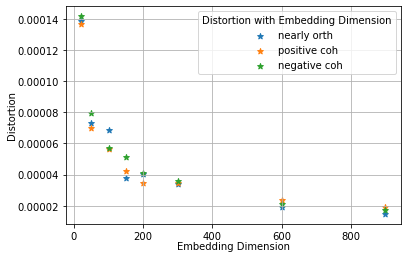

In [80]:
plt.figure()
plt.title("", pad = 20, loc = "center")
plt.scatter([900,600,300,200,150,100,50,20] , avg_o,  label= "nearly orth",marker = "*")
plt.scatter([900,600,300,200,150,100,50,20], avg_p,label= "positive coh",marker = "*")
plt.scatter([900,600,300,200,150,100,50,20], avg_n,label= "negative coh",marker = "*")
plt.legend(title="Distortion with Embedding Dimension")
plt.xlabel(xlabel="Embedding Dimension",labelpad = 0)
plt.ylabel(ylabel="Distortion",labelpad = 0)
plt.grid()
plt.savefig('cp_coherence_analysis.png', dpi=300,  bbox_inches="tight")

In [3]:
def vectorize_1(X): ##Vectorisation for tensors
    x=X.numpy()
    x=x.reshape(-1)
    return x

def vectorize(X):  ##Vecorisation for numpy arrays
    x=X
    x=x.reshape(-1)
    return x

In [4]:

def low_rank_approx(tensor,r):    
    #torch.manual_seed(0)
    factors = parafac(tl.tensor(tensor), rank=r)
    answer = tl.cp_to_tensor(factors)
    return answer

In [19]:
##### Recovery via TRIP not possible via TIHT!! Doesn't converge!

n=(10,10,10)


X = random_low_cp_rank_coh_pos(n,3)
X_ravel = np.ravel(X)
X_ravel = X_ravel/np.linalg.norm(X_ravel)

AA = np.sqrt(1/800)*np.random.normal(0.0, 1.0, [800, 1000])

vXX = torch.randn(n)
print(np.linalg.norm(vectorize(vXX)- X_ravel))
yy = np.matmul(AA, np.array(vectorize(X_ravel)))
Diff = np.linalg.norm(vectorize(vXX)- X_ravel)/np.linalg.norm(X_ravel)
print(Diff)


31.099569886351045
31.09956988635105


In [20]:

j = 0
num_its = 200

while j < num_its and Diff > 0.001:
    WW = np.array(vectorize(vXX)) + 1* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize(vXX)))))
    WW = torch.reshape(torch.tensor(WW), n)
    vXX = low_rank_approx(WW,2)
    Diff = np.linalg.norm(vectorize(vXX)- X_ravel)
    #print(Diff)
    j = j + 1
    print("Iteration:", j, "Error: ", Diff )


Iteration: 1 Error:  12.272306893056466
Iteration: 2 Error:  5.748568862397444
Iteration: 3 Error:  3.23251801274413
Iteration: 4 Error:  1.8168604998872382
Iteration: 5 Error:  0.9609868393415878
Iteration: 6 Error:  0.3604337382646548
Iteration: 7 Error:  0.12079382933314796
Iteration: 8 Error:  0.05542646562203262
Iteration: 9 Error:  0.028813251139487392
Iteration: 10 Error:  0.016346694977982214
Iteration: 11 Error:  0.009583903153165358
Iteration: 12 Error:  0.006332901971684661
Iteration: 13 Error:  0.004441744231954077
Iteration: 14 Error:  0.003803657570589065
Iteration: 15 Error:  0.003407460202441498
Iteration: 16 Error:  0.003348906206149124
Iteration: 17 Error:  0.0032746460762915447
Iteration: 18 Error:  0.003279910303097302
Iteration: 19 Error:  0.003263178750393809
Iteration: 20 Error:  0.0032682318569160424
Iteration: 21 Error:  0.0032635666848662434
Iteration: 22 Error:  0.0032657229745158465
Iteration: 23 Error:  0.0032642411756682913
Iteration: 24 Error:  0.00326504